In [1]:
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt
from math import nan
import sys
import xesmf as xe

from smyleutils import mapplot_utils as mymaps
from smyleutils import averaging_utils as avg
from smyleutils import bootstrap_utils as boot
from smyleutils import histoplot_utils as histo
from smyleutils import colorbar_utils as cbars
import cartopy.crs as ccrs
import importlib
importlib.reload(avg)
importlib.reload(boot)
import warnings
warnings.filterwarnings('ignore')

In [2]:
ystart=1979 ; yend=2020

In [3]:
plotpath="/glade/campaign/cgd/cas/islas/python_plots/NCAR_CW3E_SMYLE/FIGURES/"

### Read in the zonal mean zonal wind

In [ ]:
basepath="/glade/campaign/cgd/cas/islas/python_savs/NCAR_CW3E_SMYLE/DATA_SORT/Uzm/"
uzm_era5 = xr.open_dataset(basepath+"Uzm_ERA5_day_init11.nc").Uzm.sel(time=slice("1970-12-01","1971-02-28")).mean('time')
uzm_jra3q = xr.open_dataset(basepath+"Uzm_JRA3Q_day_init11.nc").Uzm.sel(time=slice("1970-12-01","1971-02-28")).mean('time')
uzm_l83 = xr.open_dataset(basepath+"Uzm_BSMYLE-CW3E-L83_day_init11.nc").Uzm.sel(time=slice("1970-12-01","1971-02-28")).mean('time')
uzm_l32 = xr.open_dataset(basepath+"Uzm_BSMYLE-CW3E_day_init11.nc").Uzm.sel(time=slice("1970-12-01","1971-02-28")).mean('time')

### Calculate the QBO winds (5S-5N, 50 hPa)

In [ ]:
qbo_era5 = avg.cosweightlat(uzm_era5, -5, 5)
qbo_jra3q = avg.cosweightlat(uzm_jra3q, -5, 5)
qbo_l83 = avg.cosweightlat(uzm_l83, -5, 5)
qbo_l32 = avg.cosweightlat(uzm_l32, -5, 5)

qbo_era5 = qbo_era5.interp(level=50.)
qbo_jra3q = qbo_jra3q.interp(pre=50.)
qbo_l83 = qbo_l83.interp(ilev=50.)
qbo_l32 = qbo_l32.interp(ilev=50.)

### Read in the MJO filtered OLR

In [ ]:
basepath="/glade/campaign/cgd/cas/islas/python_savs/NCAR_CW3E_SMYLE/DATA_SORT/MJO_OLR/"
mjo_era5 = xr.open_dataset(basepath+"MJOfilteredOLR_ERA5_init11.nc").std('time').sel(lat=slice(-40,40))
mjo_jra3q = xr.open_dataset(basepath+"MJOfilteredOLR_JRA3Q_init11.nc").std('time').sel(lat=slice(-40,40))
mjo_l83 = xr.open_dataset(basepath+"MJOfilteredOLR_SMYLE_L83_init11.nc")
mjo_l83['init_year'] = np.arange(1970,2020+1,1)
mjo_l32 = xr.open_dataset(basepath+"MJOfilteredOLR_SMYLE_L32_init11.nc")
mjo_l32['init_year'] = np.arange(1970,2020+1,1)

### Read in SST for the Nino3.4 index

In [ ]:
basepath="/glade/campaign/cgd/cas/islas/python_savs/NCAR_CW3E_SMYLE/DATA_SORT/SST/"
sst_obs = xr.open_dataset(basepath+"SST_ERSSTv5_mon_init11.nc").mean('time')
sst_l83 = xr.open_dataset(basepath+"SST_BSMYLE-CW3E-L83_mon_init11.nc").sel(time=slice("1970-12-01","1971-02-28")).mean('time')-273.15
sst_l32 = xr.open_dataset(basepath+"SST_BSMYLE-CW3E-L32_mon_init11.nc").sel(time=slice("1970-12-01","1971-02-28")).mean('time')-273.15

### Get them all on the same grid, grab out the low latitudes for the SSTs

In [ ]:
grid = xr.Dataset({'lat':(['lat'], mjo_era5.lat.values)}, {'lon':(['lon'], mjo_era5.lon.values)})
regridder = xe.Regridder(sst_obs, grid, 'bilinear', periodic=True, reuse_weights=False,
                         filename='/glade/derecho/scratch/islas/temp/wgt.nc')
sst_obs = regridder(sst_obs.sst)

sst_obs = sst_obs.sel(lat=slice(-40,40))
sst_l83 = sst_l83.sel(lat=slice(-40,40))
sst_l32 = sst_l32.sel(lat=slice(-40,40))

sst_l83['lon'] = grid.lon ; sst_l83['lat'] = grid.lat
sst_l32['lon'] = grid.lon ; sst_l32['lat'] = grid.lat
mjo_l83['lon'] = grid.lon ; mjo_l83['lat'] = grid.lat
mjo_l32['lon'] = grid.lon ; mjo_l32['lat'] = grid.lat
mjo_era5['lon'] = grid.lon ; mjo_era5['lat'] = grid.lat
mjo_jra3q['lon'] = grid.lon ; mjo_jra3q['lat'] = grid.lat

### Grab out the start year to end year range

In [ ]:
qbo_era5 = qbo_era5.sel(init_year=slice(ystart,yend))
qbo_jra3q = qbo_jra3q.sel(init_year=slice(ystart,yend))
sst_obs = sst_obs.sel(init_year=slice(ystart,yend))
mjo_era5 = mjo_era5.sel(init_year=slice(ystart,yend))
mjo_jra3q = mjo_jra3q.sel(init_year=slice(ystart,yend))

qbo_l83 = qbo_l83.sel(init_year=slice(ystart,yend))
sst_l83 = sst_l83.sel(init_year=slice(ystart,yend))
mjo_l83 = mjo_l83.sel(init_year=slice(ystart,yend))

qbo_l32 = qbo_l32.sel(init_year=slice(ystart,yend))
sst_l32 = sst_l32.sel(init_year=slice(ystart,yend))
mjo_l32 = mjo_l32.sel(init_year=slice(ystart,yend))

### Composite QBO westerly and easterly

In [ ]:
# compositing westerly and easterly QBO
# defining the QBO phase based on the anomalies from the climatological average
# westerly QBO is where the qbo winds are greater than 0.5 times the interannual standard deviation
# easterly QBO is where the qbo winds are less than -0.5 times the interannual standard deviation
def composite_w_e(qbo, sst, mjo, timevar='init_year'):
    qbo = qbo - qbo.mean(timevar)
    sst = sst - sst.mean(timevar)
    mjo = mjo - mjo.mean(timevar)
    
    qbo_w = qbo.where(qbo > 0.5*qbo.std(timevar), nan).mean(timevar, skipna=True).rename('u_w')
    qbo_e = qbo.where(qbo < -0.5*qbo.std(timevar), nan).mean(timevar, skipna=True).rename('u_e')
    sst_w = sst.where(qbo > 0.5*qbo.std(timevar), nan).mean(timevar, skipna=True).rename('sst_w')
    sst_e = sst.where(qbo < -0.5*qbo.std(timevar), nan).mean(timevar, skipna=True).rename('sst_e')
    mjo_w = mjo.where(qbo > 0.5*qbo.std(timevar), nan).mean(timevar, skipna=True).rename('mjo_w')
    mjo_e = mjo.where(qbo < -0.5*qbo.std(timevar), nan).mean(timevar, skipna=True).rename('mjo_e')
    
    datout = xr.merge([qbo_w, qbo_e, sst_w, sst_e, mjo_w, mjo_e])
    return datout

In [ ]:
#---Compositing based on the observed QBO
era5_comp = composite_w_e(qbo_era5, sst_obs, mjo_era5.MJO_OLR)
jra3q_comp = composite_w_e(qbo_jra3q, sst_obs, mjo_jra3q.MJO_OLR) 
l83_comp = composite_w_e(qbo_era5, sst_l83.TS, mjo_l83.MJO_OLR)
l32_comp = composite_w_e(qbo_era5, sst_l32.TS, mjo_l32.MJO_OLR)

### Grab out the area average in the box for the MJO and for Nino3.4

In [ ]:
mjo_era5_region = avg.cosweightlonlat(mjo_era5.MJO_OLR, 50, 170, -20, 5)
mjo_jra3q_region = avg.cosweightlonlat(mjo_jra3q.MJO_OLR, 50, 170, -20, 5)
mjo_l83_region = avg.cosweightlonlat(mjo_l83.MJO_OLR, 50, 170, -20, 5)
mjo_l32_region = avg.cosweightlonlat(mjo_l32.MJO_OLR, 50, 170, -20, 5)

sst_obs_region = avg.cosweightlonlat(sst_obs, 190, 240, -5, 5)
sst_l83_region = avg.cosweightlonlat(sst_l83, 190, 240, -5, 5)
sst_l32_region = avg.cosweightlonlat(sst_l32, 190, 240, -5, 5)

### Bootstrapping single member samples

In [ ]:
boot_mjo_l83 = [] ; boot_sst_l83 = [] ; boot_qbo_l83 = []
boot_mjo_l32 = [] ; boot_sst_l32 = [] ; boot_qbo_l32 = []
for iyear in np.arange(0,mjo_era5.init_year.size,1):
    boot_mjo = boot.bootgen(mjo_l83_region.isel(init_year=iyear), nsamples=1, seed=iyear).isel(isample=0)
    boot_sst = boot.bootgen(sst_l83_region.TS.isel(init_year=iyear), nsamples=1, seed=iyear).isel(isample=0)
    boot_qbo = boot.bootgen(qbo_l83.isel(init_year=iyear), nsamples=1, seed=iyear).isel(isample=0)
    boot_mjo_l83.append(boot_mjo)
    boot_sst_l83.append(boot_sst)
    boot_qbo_l83.append(boot_qbo)
    
    boot_mjo = boot.bootgen(mjo_l32_region.isel(init_year=iyear), nsamples=1, seed=iyear).isel(isample=0)
    boot_sst = boot.bootgen(sst_l32_region.TS.isel(init_year=iyear), nsamples=1, seed=iyear).isel(isample=0)
    boot_qbo = boot.bootgen(qbo_l32.isel(init_year=iyear), nsamples=1, seed=iyear).isel(isample=0)
    boot_mjo_l32.append(boot_mjo)
    boot_sst_l32.append(boot_sst)
    boot_qbo_l32.append(boot_qbo)     
    
boot_mjo_l83 = xr.concat(boot_mjo_l83, dim=mjo_era5.init_year)
boot_sst_l83 = xr.concat(boot_sst_l83, dim=mjo_era5.init_year)
boot_qbo_l83 = xr.concat(boot_qbo_l83, dim=mjo_era5.init_year)

boot_mjo_l32 = xr.concat(boot_mjo_l32, dim=mjo_era5.init_year)
boot_sst_l32 = xr.concat(boot_sst_l32, dim=mjo_era5.init_year)
boot_qbo_l32 = xr.concat(boot_qbo_l32, dim=mjo_era5.init_year)

In [ ]:
boot_qbo_obs = xr.DataArray(np.zeros([boot_qbo_l83.init_year.size, boot_qbo_l83.iboot.size]), dims=['init_year','iboot'], 
                            coords=[boot_qbo_l83.init_year, boot_qbo_l83.iboot], name='boot_qbo_obs')
boot_qbo_obs = qbo_era5.broadcast_like(boot_qbo_obs)

In [ ]:
# composites for regions
bootcomp_l83 = composite_w_e(boot_qbo_obs, boot_sst_l83, boot_mjo_l83)
bootcomp_l32 = composite_w_e(boot_qbo_obs, boot_sst_l32, boot_mjo_l32)
compregions_era5 = composite_w_e(qbo_era5, sst_obs_region, mjo_era5_region)
compregions_jra3q = composite_w_e(qbo_jra3q, sst_obs_region, mjo_jra3q_region)
compregions_l83 = composite_w_e(qbo_era5, sst_l83_region.TS, mjo_l83_region)
compregions_l32 = composite_w_e(qbo_era5, sst_l32_region.TS, mjo_l32_region)

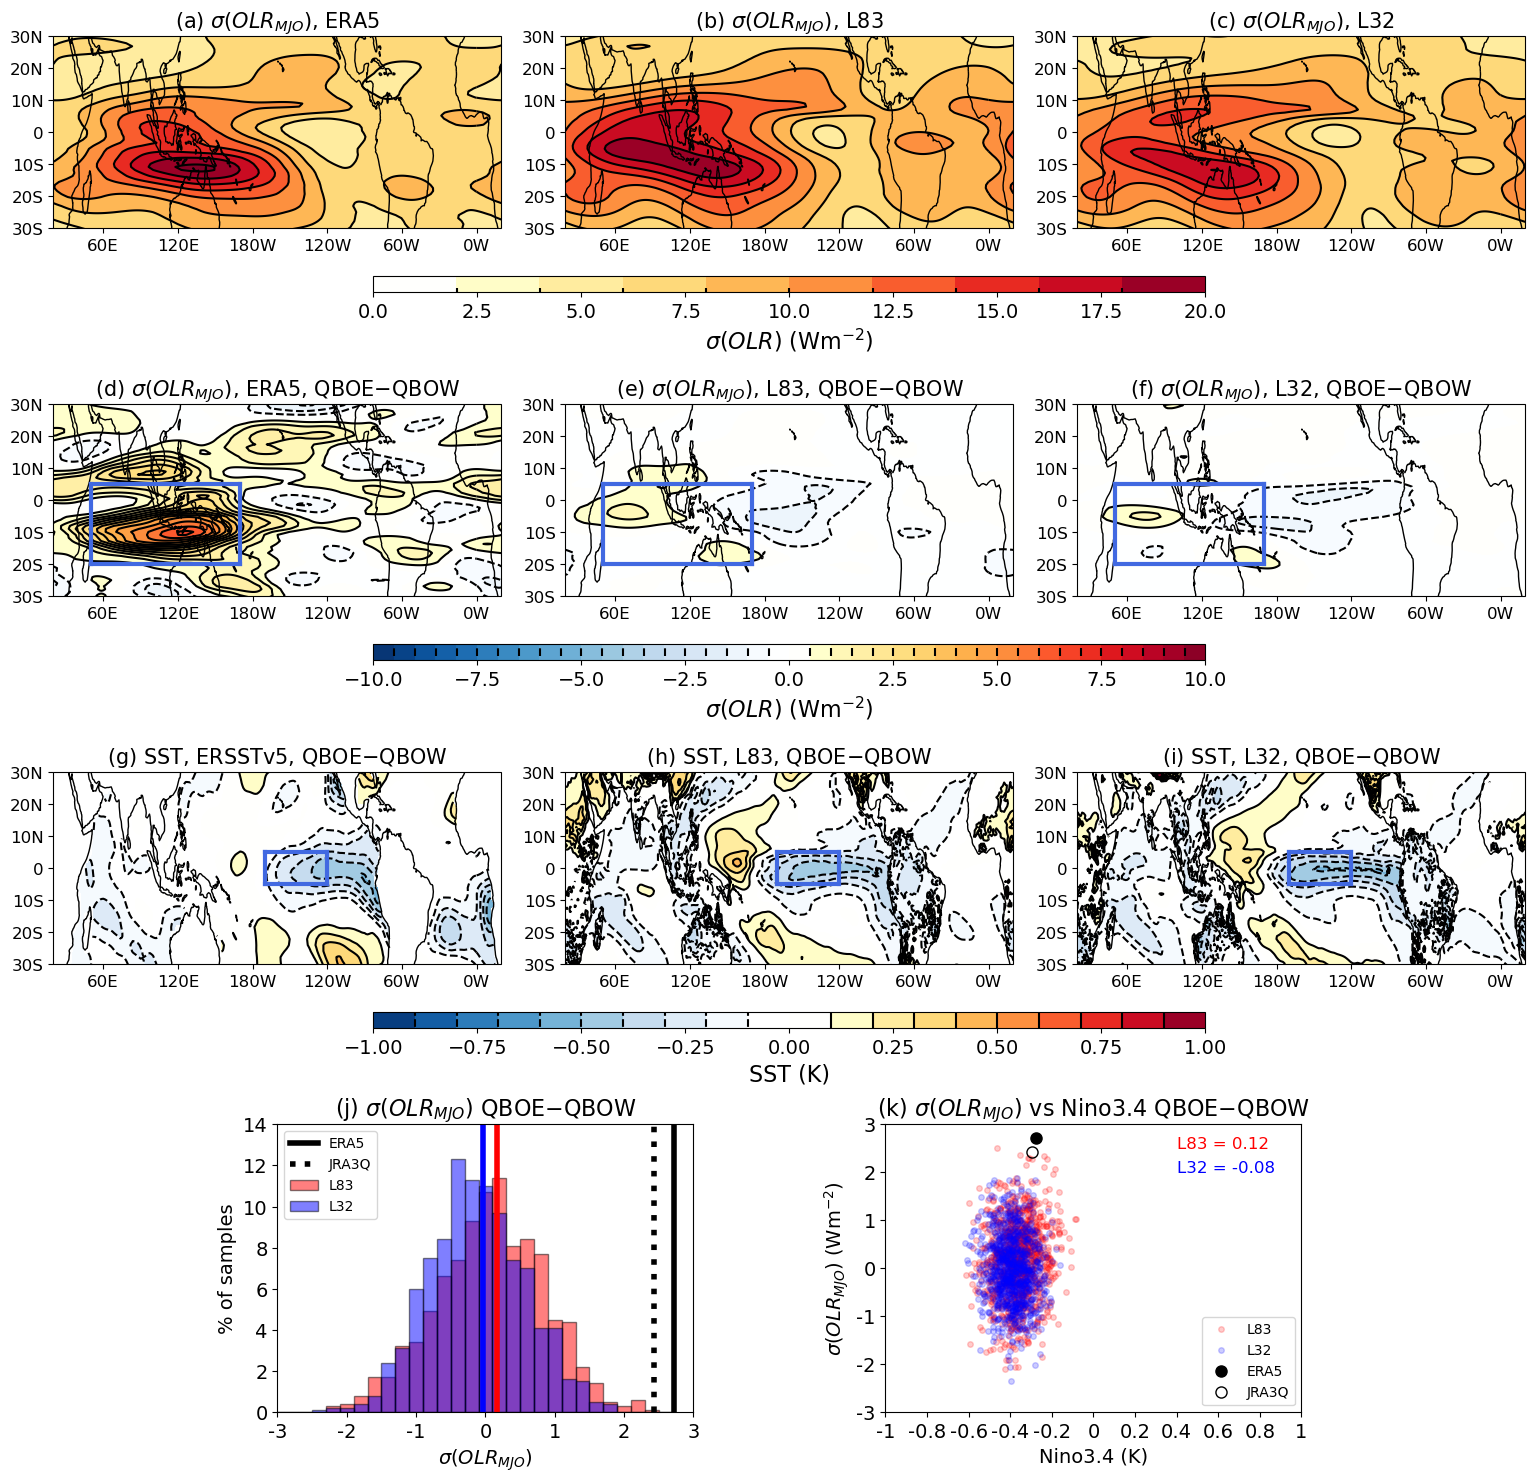

In [39]:
fig = plt.figure(figsize=(16,16))


ci=2 ; cmax=20
ax = mymaps.contourmap_bothoceans_tropics_fill_pos(fig, mjo_era5.MJO_OLR.mean('init_year'),
                                                   mjo_era5.lon, mjo_era5.lat, ci, -1.*cmax, cmax,
                                                   '(a) $\sigma(OLR_{MJO})$, ERA5', 
                                                   0.02,0.3,0.9,1.02, contourlines=True)

ax = mymaps.contourmap_bothoceans_tropics_fill_pos(fig, mjo_l83.MJO_OLR.mean(['init_year','M']),
                                                   mjo_l83.lon, mjo_l83.lat, ci, -1.*cmax, cmax,
                                                   '(b) $\sigma(OLR_{MJO})$, L83',
                                                   0.34,0.62,0.9,1.02, contourlines=True)

ax = mymaps.contourmap_bothoceans_tropics_fill_pos(fig, mjo_l32.MJO_OLR.mean(['init_year','M']),
                                                   mjo_l32.lon, mjo_l32.lat, ci, -1.*cmax, cmax,
                                                   '(c) $\sigma(OLR_{MJO})$, L32',
                                                   0.66,0.94,0.9,1.02, contourlines=True)

ax = cbars.plotcolorbar(fig, ci, -1.*cmax, cmax, '$\sigma(OLR)$ (Wm$^{-2}$)',
                        0.22,0.74,0.86,0.87,contourlines=True, posneg='pos')



ci = 0.5 ; cmax = 10

ax = mymaps.contourmap_bothoceans_tropics_fill_pos(fig, era5_comp.mjo_e - era5_comp.mjo_w ,
                                                   era5_comp.lon, era5_comp.lat, ci, -1.*cmax, cmax,
                                                   '(d) $\sigma(OLR_{MJO})$, ERA5, QBOE$-$QBOW',0.02,0.3,0.67,0.79,contourlines=True)
ax.plot([50,170],[-20,-20], color='royalblue', transform=ccrs.PlateCarree(), linewidth=3)
ax.plot([50,170],[5,5], color='royalblue', transform=ccrs.PlateCarree(), linewidth=3)
ax.plot([50,50],[-20,5], color='royalblue', transform=ccrs.PlateCarree(), linewidth=3)
ax.plot([170,170],[-20,5], color='royalblue', transform=ccrs.PlateCarree(), linewidth=3)


ax = mymaps.contourmap_bothoceans_tropics_fill_pos(fig, l83_comp.mjo_e.mean('M') - l83_comp.mjo_w.mean('M'),
                                                   l83_comp.lon, l83_comp.lat, ci, -1.*cmax, cmax,
                                                   '(e) $\sigma(OLR_{MJO})$, L83, QBOE$-$QBOW',0.34,0.62,0.67,0.79, contourlines=True)
ax.plot([50,170],[-20,-20], color='royalblue', transform=ccrs.PlateCarree(), linewidth=3)
ax.plot([50,170],[5,5], color='royalblue', transform=ccrs.PlateCarree(), linewidth=3)
ax.plot([50,50],[-20,5], color='royalblue', transform=ccrs.PlateCarree(), linewidth=3)
ax.plot([170,170],[-20,5], color='royalblue', transform=ccrs.PlateCarree(), linewidth=3)


ax = mymaps.contourmap_bothoceans_tropics_fill_pos(fig, l32_comp.mjo_e.mean('M') - l32_comp.mjo_w.mean('M'),
                                                   l32_comp.lon, l32_comp.lat, ci, -1.*cmax, cmax,
                                                   '(f) $\sigma(OLR_{MJO})$, L32, QBOE$-$QBOW',0.66,0.94,0.67,0.79, contourlines=True)
ax.plot([50,170],[-20,-20], color='royalblue', transform=ccrs.PlateCarree(), linewidth=3)
ax.plot([50,170],[5,5], color='royalblue', transform=ccrs.PlateCarree(), linewidth=3)
ax.plot([50,50],[-20,5], color='royalblue', transform=ccrs.PlateCarree(), linewidth=3)
ax.plot([170,170],[-20,5], color='royalblue', transform=ccrs.PlateCarree(), linewidth=3)

ax = cbars.plotcolorbar(fig, ci, -1.*cmax, cmax, '$\sigma(OLR)$ (Wm$^{-2}$)',
                        0.22,0.74,0.63,0.64,contourlines=True)




ci=0.1 ; cmax=1

ax = mymaps.contourmap_bothoceans_tropics_fill_pos(fig, era5_comp.sst_e - era5_comp.sst_w,
                                                   era5_comp.lon, era5_comp.lat, ci, -1.*cmax, cmax,
                                                   '(g) SST, ERSSTv5, QBOE$-$QBOW',
                                                   0.02,0.3,0.44,0.56, contourlines=True)
ax.plot([190,240],[-5,-5], color='royalblue', transform=ccrs.PlateCarree(), linewidth=3)
ax.plot([190,240],[5,5], color='royalblue', transform=ccrs.PlateCarree(), linewidth=3)
ax.plot([190,190],[-5,5], color='royalblue', transform=ccrs.PlateCarree(), linewidth=3)
ax.plot([240,240],[-5,5], color='royalblue', transform=ccrs.PlateCarree(), linewidth=3)


ax = mymaps.contourmap_bothoceans_tropics_fill_pos(fig, l83_comp.sst_e.mean('M') - l83_comp.sst_w.mean('M'),
                                                   l83_comp.lon, l83_comp.lat, ci, -1.*cmax, cmax,
                                                   '(h) SST, L83, QBOE$-$QBOW',
                                                   0.34,0.62,0.44,0.56, contourlines=True)
ax.plot([190,240],[-5,-5], color='royalblue', transform=ccrs.PlateCarree(), linewidth=3)
ax.plot([190,240],[5,5], color='royalblue', transform=ccrs.PlateCarree(), linewidth=3)
ax.plot([190,190],[-5,5], color='royalblue', transform=ccrs.PlateCarree(), linewidth=3)
ax.plot([240,240],[-5,5], color='royalblue', transform=ccrs.PlateCarree(), linewidth=3)


ax = mymaps.contourmap_bothoceans_tropics_fill_pos(fig, l32_comp.sst_e.mean('M') - l32_comp.sst_w.mean('M'),
                                                   l32_comp.lon, l32_comp.lat, ci, -1.*cmax, cmax,
                                                   '(i) SST, L32, QBOE$-$QBOW',
                                                   0.66,0.94,0.44,0.56, contourlines=True)
ax.plot([190,240],[-5,-5], color='royalblue', transform=ccrs.PlateCarree(), linewidth=3)
ax.plot([190,240],[5,5], color='royalblue', transform=ccrs.PlateCarree(), linewidth=3)
ax.plot([190,190],[-5,5], color='royalblue', transform=ccrs.PlateCarree(), linewidth=3)
ax.plot([240,240],[-5,5], color='royalblue', transform=ccrs.PlateCarree(), linewidth=3)


ax = cbars.plotcolorbar(fig, ci, -1.*cmax, cmax, 'SST (K)',
                        0.22,0.74,0.4,0.41,contourlines=True)



ax = fig.add_axes([0.16,0.16,0.26,0.18])
ax.set_ylim(0,14)
ax.set_yticks([0,2,4,6,8,10,12,14])
ax.set_yticklabels(['0','2','4','6','8','10','12','14'], fontsize=14)
ax.set_xlim(-3,3)
ax.set_xticks([-3,-2,-1,0,1,2,3])
ax.set_xticklabels(['-3','-2','-1','0','1','2','3'], fontsize=14)
ax.set_xlabel('$\sigma(OLR_{MJO})$', fontsize=14)
ax.set_ylabel('% of samples', fontsize=14)
ax.set_title('(j) $\sigma(OLR_{MJO})$ QBOE$-$QBOW', fontsize=16)
ax = histo.oplothisto(ax, bootcomp_l83.mjo_e - bootcomp_l83.mjo_w, np.arange(-3,3,0.2), 
                      percent=True, color='red', alpha=0.5, label='L83')
ax = histo.oplothisto(ax, bootcomp_l32.mjo_e - bootcomp_l32.mjo_w, np.arange(-3,3,0.2),
                      percent=True, color='blue', alpha=0.5, label='L32')
ax.plot([compregions_era5.mjo_e - compregions_era5.mjo_w, 
         compregions_era5.mjo_e - compregions_era5.mjo_w],[0,14], color='black', linewidth=4, label='ERA5')
ax.plot([compregions_jra3q.mjo_e - compregions_jra3q.mjo_w, 
         compregions_jra3q.mjo_e - compregions_jra3q.mjo_w],[0,14], color='black', linewidth=4, label='JRA3Q', linestyle='dotted')

ax.plot([compregions_l83.mjo_e.mean('M') - compregions_l83.mjo_w.mean('M'), 
         compregions_l83.mjo_e.mean('M') - compregions_l83.mjo_w.mean('M')],[0,14], color='red', linewidth=4)
ax.plot([compregions_l32.mjo_e.mean('M') - compregions_l32.mjo_w.mean('M'), 
         compregions_l32.mjo_e.mean('M') - compregions_l32.mjo_w.mean('M')],[0,14], color='blue', linewidth=4)
ax.legend(loc='upper left')



ax = fig.add_axes([0.54,0.16,0.26,0.18])
ax.set_xlim(-1,1)
ax.set_ylim(-3,3)
ax.set_xticks([-1,-0.8,-0.6,-0.4,-0.2,0,0.2,0.4,0.6,0.8,1])
ax.set_xticklabels(['-1','-0.8','-0.6','-0.4','-0.2','0','0.2','0.4','0.6','0.8','1'], fontsize=14)
ax.set_yticks([-3,-2,-1,0,1,2,3])
ax.set_yticklabels(['-3','-2','-1','0','1','2','3'], fontsize=14)
ax.set_title('(k) $\sigma(OLR_{MJO})$ vs Nino3.4 QBOE$-$QBOW', fontsize=16)
ax.set_xlabel('Nino3.4 (K)', fontsize=14)
ax.set_ylabel('$\sigma(OLR_{MJO})$ (Wm$^{-2}$)', fontsize=14)

r_l83 = xr.corr(bootcomp_l83.sst_e - bootcomp_l83.sst_w, bootcomp_l83.mjo_e - bootcomp_l83.mjo_w)
r_l32 = xr.corr(bootcomp_l32.sst_e - bootcomp_l32.sst_w, bootcomp_l32.mjo_e - bootcomp_l32.mjo_w)

rboot_l83 = boot.boot_corcoefs(bootcomp_l83.sst_e - bootcomp_l83.sst_w, bootcomp_l83.mjo_e - bootcomp_l83.mjo_w)
rboot_l32 = boot.boot_corcoefs(bootcomp_l32.sst_e - bootcomp_l32.sst_w, bootcomp_l32.mjo_e - bootcomp_l32.mjo_w)

min95_l83 = rboot_l83.quantile(0.025, dim='boot')
max95_l83 = rboot_l83.quantile(0.975, dim='boot')

min95_l32 = rboot_l32.quantile(0.025, dim='boot')
max95_l32 = rboot_l32.quantile(0.975, dim='boot')



ax.plot(bootcomp_l83.sst_e - bootcomp_l83.sst_w, bootcomp_l83.mjo_e - bootcomp_l83.mjo_w,"o", color='red', alpha=0.2, markersize=4,label='L83')
ax.plot(bootcomp_l32.sst_e - bootcomp_l32.sst_w, bootcomp_l32.mjo_e - bootcomp_l32.mjo_w,"o", color='blue', alpha=0.2, markersize=4, label='L32')
ax.plot(compregions_era5.sst_e - compregions_era5.sst_w, compregions_era5.mjo_e - compregions_era5.mjo_w, "o", color='black', markersize=8, label='ERA5')
ax.plot(compregions_jra3q.sst_e - compregions_jra3q.sst_w, compregions_jra3q.mjo_e - compregions_jra3q.mjo_w, "o", markerfacecolor='None',
        markeredgecolor='black', markersize=8, label='JRA3Q')

ax.text(0.4,2.5,"L83 = {:.2f}".format(r_l83.item()), color='red', fontsize=12)
ax.text(0.4,2.,"L32 = {:.2f}".format(r_l32.item()), color='blue', fontsize=12)


ax.legend(loc='lower right')

fig.savefig(plotpath+'fig13.png', bbox_inches='tight', facecolor='white')

In [38]:
import warnings
warnings.filterwarnings('ignore')

In [40]:
dif_l83 = bootcomp_l83.mjo_e - bootcomp_l83.mjo_w
dif_l32 = bootcomp_l32.mjo_e - bootcomp_l32.mjo_w
dif_jra = compregions_jra3q.mjo_e - compregions_jra3q.mjo_w

In [43]:
test = dif_l32[dif_l32 > dif_jra]

In [44]:
test

<xarray.DataArray (iboot: 0)>
array([], dtype=float64)
Coordinates:
    zlon     float64 0.0
    level    float64 50.0
  * iboot    (iboot) int64 
    isample  int64 0
    pre      float64 50.0